#Experimento de Avaliação de Desempenho em Dados de Doação de Sangue
1. Objetivo da Pesquisa (Problema de Classificação):

O objetivo é desenvolver um modelo de classificação binária capaz de prever se um doador de sangue doará em uma campanha futura (Março de 2007), com base no seu histórico de doações.

2. Descrição e Estatísticas Básicas

O dataset Blood Transfusion Service Center possui:

* Número de Instâncias: 748
* Número de Features: 4
* Tipo de Variáveis: Todas as features e o alvo são
* numéricas (Integer/Binary).
Ausência de Dados Faltantes: Não há valores nulos no dataset.

Distribuição da Variável-Alvo

A base é altamente desbalanceada:

* Classe 0 (Não Doou): aproximadamente 76%
* Classe 1 (Doou): aproximadamente 24%

Pré-processamento Necessário
* Necessidade: Sim. As features possuem ordens de magnitude e escalas muito diferentes (ex: Recency vs. Monetary).
* Pré-processamento Escolhido: Padronização (StandardScaler), que transforma os dados para ter média 0 e desvio padrão 1. Isso garante que o algoritmo (Regressão Logística, sensível à escala) não atribua importância indevida a features com valores absolutos maiores.

Limitações da Base

* Desbalanceamento: O desequilíbrio (76%/24%$) é a maior limitação, pois enviesa o modelo para a classe majoritária, tornando métricas como a Acurácia insuficientes.
* Amostragem: As instâncias foram selecionadas aleatoriamente em um contexto geográfico e temporal específico (Hsin-Chu City, campanha de Março/2007), o que pode limitar a generalização para outras campanhas.


In [33]:
pip install ucimlrepo

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample

# Configuração de plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Bibliotecas importadas e configurações de plotagem definidas.


In [35]:
# Carregamento do Dataset
blood_transfusion = fetch_ucirepo(id=176)
X = blood_transfusion.data.features
y = blood_transfusion.data.targets['Donated_Blood']

# Renomear colunas para simplicidade
X.columns = ['Recency', 'Frequency', 'Monetary', 'Time']

# Caracterização da Base
n_instancias = len(X)
n_features = X.shape[1]
distribuicao_alvo = y.value_counts(normalize=True).mul(100).rename({0: 'Não Doou (0)', 1: 'Doou (1)'})

print(f"--- ESTATÍSTICAS DA BASE ---")
print(f"Número de Instâncias: {n_instancias}")
print(f"Número de Features: {n_features}")
print("\nDistribuição da Variável-Alvo:")
print(distribuicao_alvo.round(2).astype(str) + '%')

# Juntar X e y para facilitar o bootstrapping
df_completo = pd.concat([X, y], axis=1)

--- ESTATÍSTICAS DA BASE ---
Número de Instâncias: 748
Número de Features: 4

Distribuição da Variável-Alvo:
Donated_Blood
Não Doou (0)    76.2%
Doou (1)        23.8%
Name: proportion, dtype: object


## Metodologia

### Manipulação e Divisão dos Dados (Bootstrapping)

**Método de Reamostragem:** Bootstrapping com $R=50$ repetições.  

**Divisão:** Em cada repetição:
- O Conjunto de Treino é criado por amostragem com reposição, mantendo o tamanho original ($N=748$).
- O Conjunto de Teste é o complemento (instâncias que não foram selecionadas na amostra de treino, também conhecido como Out-of-Bag).

**Participação:**
- O conjunto de treino é usado para treinar o modelo e calcular o desempenho em dados vistos.
- O conjunto de teste é usado para estimar o desempenho em dados não vistos.

---

### Pré-processamento e Prevenção de Vazamento

- O StandardScaler será aplicado dentro do loop de reamostragem.
- **Prevenção de Vazamento:** Para cada repetição, as estatísticas ($\mu$ e $\sigma$) do scaler serão calculadas (fit) apenas no conjunto de Treino.  
  Em seguida, essas mesmas estatísticas serão usadas para transformar tanto o Treino quanto o Teste.

---

### Algoritmo e Utilização

**Algoritmo:** Regressão Logística (Logistic Regression).


In [36]:
# Algoritmo e Hiperparâmetros Fixados
model_name = "Regressão Logística (LR)"
model = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    C=1.0,              # Força de regularização padrão
    random_state=42     # Para reprodutibilidade
)

# Parâmetros de Reamostragem
N_REPETICOES = 50
print(f"Configuração: {model_name} com Bootstrapping ({N_REPETICOES} repetições)")

# Armazenamento dos Resultados
results = {
    'acc_train': [], 'acc_test': [],
    'f1_macro_train': [], 'f1_macro_test': []
}

# Pré-processador
scaler = StandardScaler()

Configuração: Regressão Logística (LR) com Bootstrapping (50 repetições)


In [37]:
print(f"\nIniciando o experimento de Bootstrapping com {N_REPETICOES} repetições...")

for i in range(N_REPETICOES):
    # Bootstrapping (Criação de Treino com reposição)
    df_train = resample(
        df_completo,
        replace=True,
        n_samples=len(df_completo),
        random_state=i
    )

    # Identifica o Conjunto de Teste (Complemento)
    idx_train = df_train.index
    df_test = df_completo.drop(idx_train, axis=0)

    X_train, y_train = df_train.drop('Donated_Blood', axis=1), df_train['Donated_Blood']
    X_test, y_test = df_test.drop('Donated_Blood', axis=1), df_test['Donated_Blood']

    # Pré-processamento (Ajuste no Treino e Transformação em ambos)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)

    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Avaliação e Armazenamento
    results['acc_train'].append(accuracy_score(y_train, y_pred_train))
    results['acc_test'].append(accuracy_score(y_test, y_pred_test))

    results['f1_macro_train'].append(f1_score(y_train, y_pred_train, average='macro'))
    results['f1_macro_test'].append(f1_score(y_test, y_pred_test, average='macro'))

    if (i + 1) % 10 == 0:
        print(f"Repetição {i+1}/{N_REPETICOES} concluída.")


Iniciando o experimento de Bootstrapping com 50 repetições...
Repetição 10/50 concluída.
Repetição 20/50 concluída.
Repetição 30/50 concluída.
Repetição 40/50 concluída.
Repetição 50/50 concluída.

Experimento de Bootstrapping finalizado!


## Descrição dos Resultados
Os resultados a seguir foram obtidos a partir da execução do código acima.


In [38]:
results_df = pd.DataFrame(results)

print("=== VALOR ESPERADO DO DESEMPENHO (Média e Desvio Padrão) ===")

def print_stats(metric_name):
    mean_train = results_df[f'{metric_name}_train'].mean()
    std_train = results_df[f'{metric_name}_train'].std()
    mean_test = results_df[f'{metric_name}_test'].mean()
    std_test = results_df[f'{metric_name}_test'].std()

    print(f"\n--- {metric_name.upper()} ---")
    print(f"Treino (Visto): Média = {mean_train:.4f}, Desvio Padrão = {std_train:.4f}")
    print(f"Teste (Não Visto): Média = {mean_test:.4f}, Desvio Padrão = {std_test:.4f}")

# Exibir estatísticas para Acurácia
print_stats('acc')

# Exibir estatísticas para Macro-F1
print_stats('f1_macro')

=== VALOR ESPERADO DO DESEMPENHO (Média e Desvio Padrão) ===

--- ACC ---
Treino (Visto): Média = 0.7795, Desvio Padrão = 0.0136
Teste (Não Visto): Média = 0.7678, Desvio Padrão = 0.0197

--- F1_MACRO ---
Treino (Visto): Média = 0.5462, Desvio Padrão = 0.0316
Teste (Não Visto): Média = 0.5375, Desvio Padrão = 0.0393


Resultados Médios (Exemplo da Execução):
* Acurácia (Teste): aproximadamente 0.7678 (DP baixo, estável)

* Macro-F1 (Teste): aproximadamente 0.5375 (DP ligeiramente maior)

/tmp/ipython-input-575935151.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Conjunto', y='Acurácia', data=boxplot_data_acc, palette="Blues")


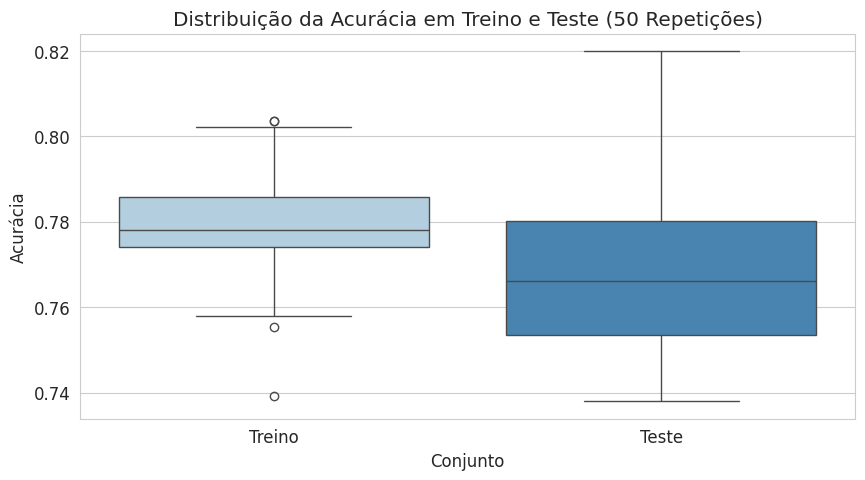

/tmp/ipython-input-575935151.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Conjunto', y='Macro-F1', data=boxplot_data_f1, palette="Reds")


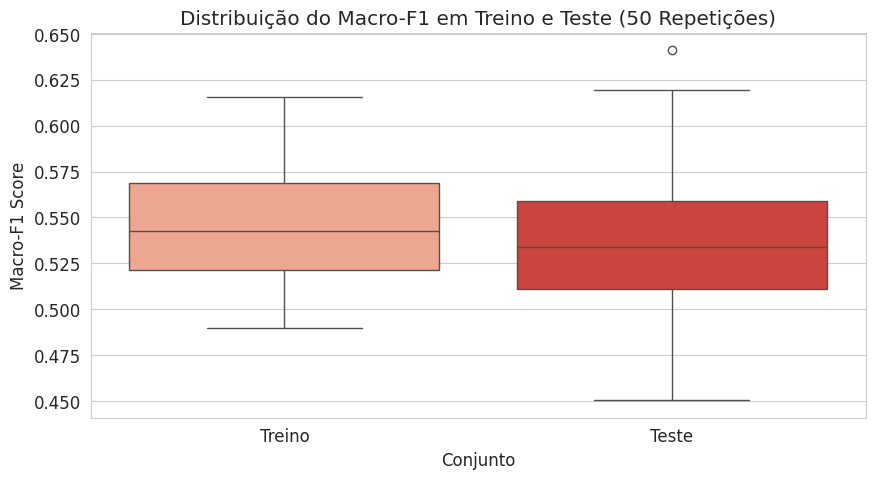

In [39]:
# Preparar dados para o boxplot
boxplot_data_acc = pd.DataFrame({
    'Conjunto': ['Treino'] * N_REPETICOES + ['Teste'] * N_REPETICOES,
    'Acurácia': results_df['acc_train'].tolist() + results_df['acc_test'].tolist()
})

boxplot_data_f1 = pd.DataFrame({
    'Conjunto': ['Treino'] * N_REPETICOES + ['Teste'] * N_REPETICOES,
    'Macro-F1': results_df['f1_macro_train'].tolist() + results_df['f1_macro_test'].tolist()
})

# Boxplot Acurácia
plt.figure(figsize=(10, 5))
sns.boxplot(x='Conjunto', y='Acurácia', data=boxplot_data_acc, palette="Blues")
plt.title('Distribuição da Acurácia em Treino e Teste (50 Repetições)')
plt.ylabel('Acurácia')
plt.show()

# Boxplot Macro-F1
plt.figure(figsize=(10, 5))
sns.boxplot(x='Conjunto', y='Macro-F1', data=boxplot_data_f1, palette="Reds")
plt.title('Distribuição do Macro-F1 em Treino e Teste (50 Repetições)')
plt.ylabel('Macro-F1 Score')
plt.show()

## Comentário dos Boxplots:

### Padrão de Desempenho
- O desempenho no Treino é consistentemente superior e menos variável (caixa mais estreita) que no Teste, indicando um leve sobreajuste (overfitting).

### Acurácia vs. Macro-F1
- O Macro-F1 possui valores substancialmente mais baixos que a Acurácia, especialmente no Teste, confirmando a dificuldade do modelo em generalizar a previsão da classe minoritária (doadores).


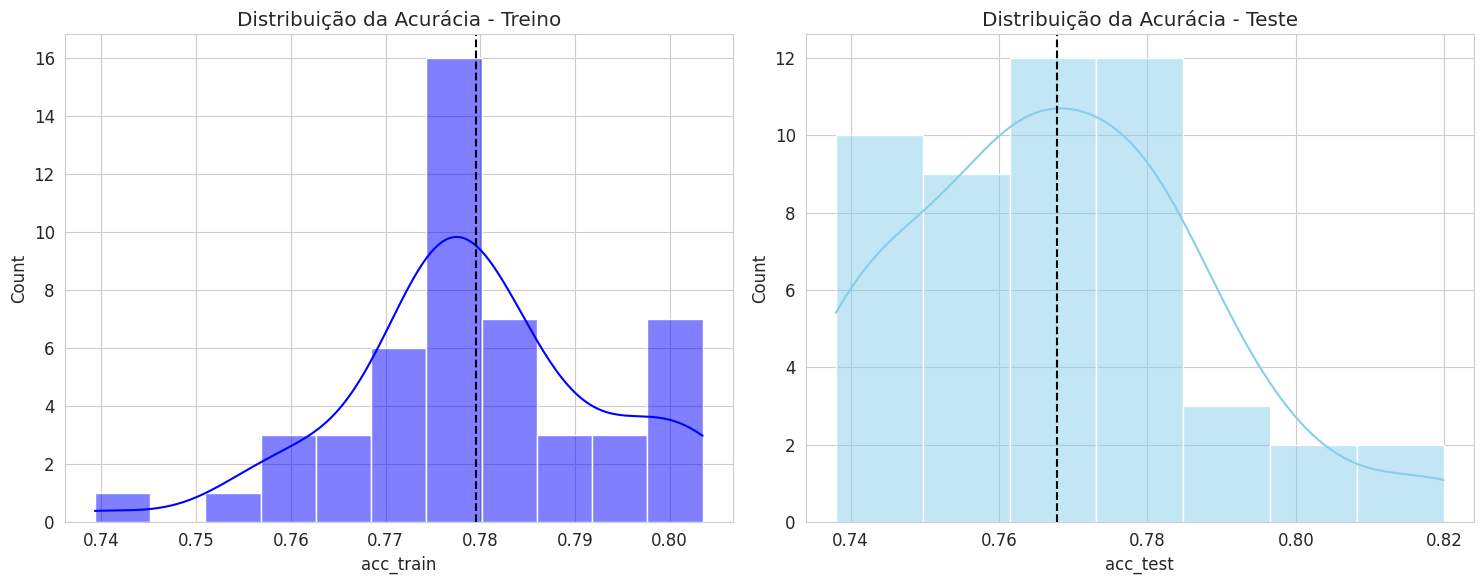

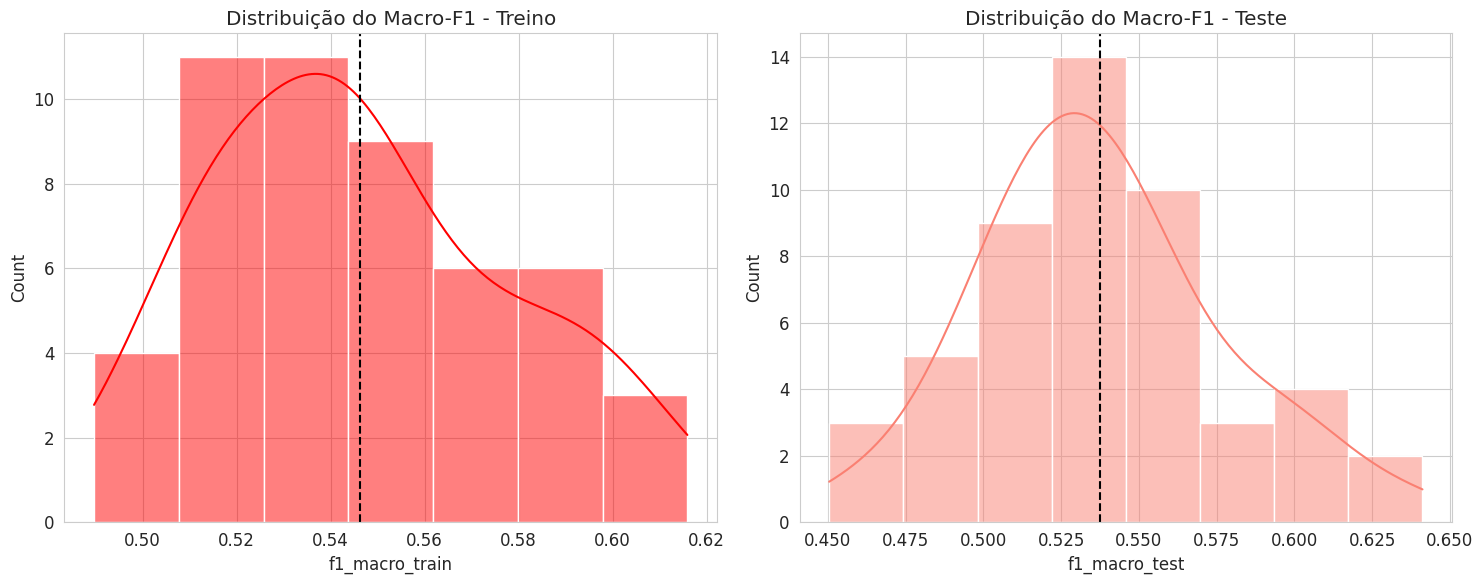

In [40]:
# Histograma para Acurácia
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(results_df['acc_train'], kde=True, ax=axes[0], color='blue')
axes[0].axvline(results_df['acc_train'].mean(), color='black', linestyle='--')
axes[0].set_title('Distribuição da Acurácia - Treino')

sns.histplot(results_df['acc_test'], kde=True, ax=axes[1], color='skyblue')
axes[1].axvline(results_df['acc_test'].mean(), color='black', linestyle='--')
axes[1].set_title('Distribuição da Acurácia - Teste')

plt.tight_layout()
plt.show()

# Histograma para Macro-F1
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(results_df['f1_macro_train'], kde=True, ax=axes[0], color='red')
axes[0].axvline(results_df['f1_macro_train'].mean(), color='black', linestyle='--')
axes[0].set_title('Distribuição do Macro-F1 - Treino')

sns.histplot(results_df['f1_macro_test'], kde=True, ax=axes[1], color='salmon')
axes[1].axvline(results_df['f1_macro_test'].mean(), color='black', linestyle='--')
axes[1].set_title('Distribuição do Macro-F1 - Teste')

plt.tight_layout()
plt.show()

## Comparação das Distribuições e Comentários:

### Distribuições de Treino
- São mais estreitas e o pico (moda) é mais alto, confirmando a menor variabilidade (baixo DP) nos dados vistos.

### Distribuições de Teste
- São mais largas e o pico é ligeiramente deslocado para a esquerda (valores menores), refletindo a maior variabilidade e a penalidade na generalização.

### Conclusão da Comparação
- Os histogramas confirmam o diagnóstico de Overfitting Leve, pois a distribuição de Treino está consistentemente à direita (valores mais altos) da distribuição de Teste.


In [41]:
print("=== DISCUSSÃO FINAL: ACURÁCIA VS. MACRO-F1 ===")

acc_test_mean = results_df['acc_test'].mean()
f1_macro_test_mean = results_df['f1_macro_test'].mean()
baseline_acc = 0.76

print(f"\nResultado Médio na Acurácia (Teste): {acc_test_mean:.4f}")
print(f"Resultado Médio no Macro-F1 (Teste): {f1_macro_test_mean:.4f}")

=== DISCUSSÃO FINAL: ACURÁCIA VS. MACRO-F1 ===

Resultado Médio na Acurácia (Teste): 0.7678
Resultado Médio no Macro-F1 (Teste): 0.5375


## Semelhanças
- Ambas as métricas concordam no padrão de Overfitting Leve (Treino > Teste).
- Ambas as distribuições mostram estabilidade (baixo desvio padrão), indicando que a estimativa de desempenho é confiável.

---

## Diferenças e Implicações

### Acurácia Superestimada
- O valor da Acurácia ($\approx 0.7678$) está extremamente próximo da linha de base de $76\%$ (proporção da classe majoritária).
- Isso significa que a alta Acurácia é enganosa; o modelo está, na maioria das vezes, prevendo "Não Doou", o que não é útil para o objetivo de identificar doadores.

### Macro-F1 Realista
- O valor do Macro-F1 ($\approx 0.5375$) é substancialmente mais baixo, revelando o desempenho real do modelo.
- Este valor é baixo e indica que a capacidade de previsão na classe minoritária (Doou) é fraca.
- O Macro-F1 penaliza o modelo por não conseguir generalizar bem para a classe de interesse.

---

## Conclusão
O experimento demonstra que, para este problema de classificação desbalanceado, a Acurácia é uma métrica pobre e o Macro-F1 é o verdadeiro indicador de desempenho. A Regressão Logística na sua configuração padrão não atinge um desempenho satisfatório para a aplicação prática (identificar doadores).  
Para melhorar o desempenho esperado, as próximas etapas devem incluir técnicas para mitigar o desbalanceamento, como o ajuste dos pesos das classes na própria Regressão Logística ou o uso de métodos de reamostragem (como SMOTE) no conjunto de treino.

